# Bayes-by-backprop

In [1]:
import jax
import optax
import distrax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Callable
from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import flax.linen as nn
from functools import partial

In [4]:
import numpy as np
from dynamax.utils import datasets
from jax.flatten_util import ravel_pytree

In [5]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist()
X_train, y_train = train

# ymean = y_train.mean()
# ystd = y_train.std()
# y_train = (y_train - ymean ) / ystd

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

In [6]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        
        return x

In [7]:
key = jax.random.PRNGKey(314)
key_init, key_train, key_eval = jax.random.split(key, 3)

batch = (100, 28 ** 2)
model = MLP(1)
batch = jnp.ones(batch)

### Initialise params

In [8]:
key_mean, key_logvar = jax.random.split(key_init)
params_mean = model.init(key_mean, batch)

num_params, reconstruct_fn = ravel_pytree(params_mean)
num_params = len(num_params)

params_logvar = jax.random.normal(key_logvar, (num_params,))
params_logvar = reconstruct_fn(params_logvar)

### Define sampling functions

In [9]:
from jaxtyping import Float, PyTree, Array
from chex import dataclass

@dataclass
class BBBParams:
    mean: PyTree[Float]
    logvar: PyTree[Float]

# Bayes-by-backprop params
b3p = BBBParams(
    mean=params_mean,
    logvar=params_logvar,
)

In [10]:
def transform(eps, mean, logvar):
    std = jnp.exp(logvar / 2)
    weight = mean + std * eps
    return weight


@partial(jax.jit, static_argnames=("num_params", "reconstruct_fn"))
def sample_params(key, state:BBBParams, num_params, reconstruct_fn:Callable):
    eps = jax.random.normal(key, (num_params,))
    eps = reconstruct_fn(eps)
    params = jax.tree_map(transform, eps, state.mean, state.logvar)
    return params


@partial(jax.jit, static_argnames=("num_params", "reconstruct_fn"))
def sample_and_eval(key, state, X, num_params, reconstruct_fn):
    params_sample = sample_params(key, state, num_params, reconstruct_fn)
    return model.apply(params_sample, X)

@jax.jit
def get_leaves(params):
    flat_params, _ = ravel_pytree(params)
    return flat_params

In [11]:
def cost_fn(
    key: jax.random.PRNGKey,
    state: BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    scale_obs=1.0,
    scale_prior=1.0,
):
    """
    TODO:
    Add more general way to compute observation-model log-probability
    """
    
    # Sampled params
    params = sample_params(key, state, num_params, reconstruct_fn)
    params_flat = get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()
    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, logvar, x: distrax.Normal(loc=mean, scale=jnp.exp(logvar / 2)).log_prob(x),
        state.mean, state.logvar, params
    )
    logp_variational = get_leaves(logp_variational).sum()
    
    return logp_variational - logp_prior - logp_obs


@partial(jax.jit)
def lossfn(key, params, X, y, num_samples=10):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, reconstruct_fn).mean()
    return loss


@partial(jax.jit, static_argnames=("num_samples", "batch_size"))
def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


In [12]:
@jax.jit
def index_values_batch(X, y, ixs):
    """
    Index values of a batch of observations
    """
    X_batch = X[ixs]
    y_batch = y[ixs]
    return X_batch, y_batch


@partial(jax.jit, static_argnames="lossfn")
def train_step(key, opt_state, X, y, lossfn):
    params = opt_state.params
    apply_fn = opt_state.apply_fn
    
    loss, grads = jax.value_and_grad(lossfn, 1)(key, params, X, y)
    opt_state_new = opt_state.apply_gradients(grads=grads)
    return opt_state_new, loss

In [13]:
def train_epoch(key, state, X, y, batch_size, lossfn):
    num_samples = len(X)
    key_batch, keys_train = jax.random.split(key)
    batch_ixs = get_batch_train_ixs(key_batch, num_samples, batch_size)
    
    num_batches = len(batch_ixs)
    keys_train = jax.random.split(keys_train, num_batches)
    
    total_loss = 0
    for key_step, batch_ix in zip(keys_train, batch_ixs):
        X_batch, y_batch = index_values_batch(X, y, batch_ix)
        state, loss = train_step(key_step, state, X_batch, y_batch, lossfn)
        total_loss += loss
    
    return total_loss.item(), state

In [14]:
tx = optax.adam(1e-3)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)

In [15]:
batch_size = 500
num_epochs = 500
keys_epochs = jax.random.split(key_train, num_epochs)

losses = []
for key_epoch in (pbar := tqdm(keys_epochs)):
    loss, opt_state = train_epoch(key, opt_state, X_train, y_train, batch_size, lossfn)
    pbar.set_description(f"{loss=:0.4e}")
    losses.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

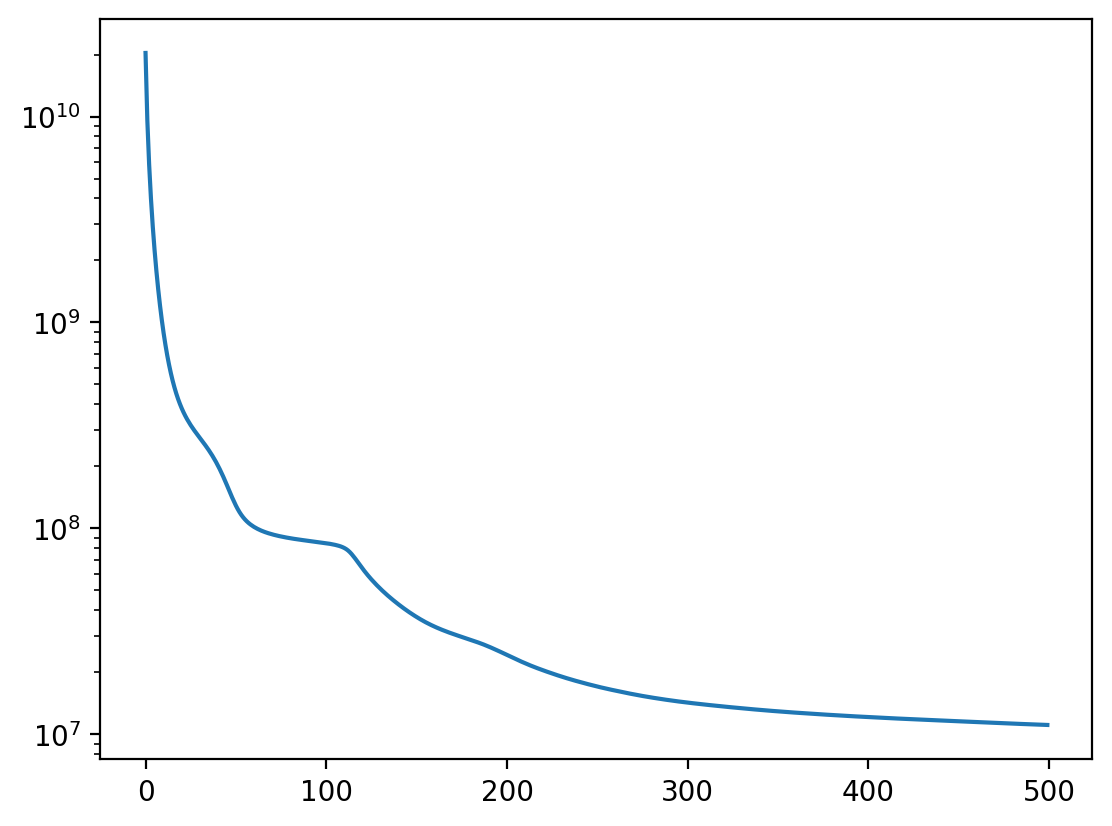

In [16]:
plt.plot(losses)
plt.yscale("log")

## Evaluating model

In [129]:
X_test, y_test = test
X_test, y_test = jnp.array(X_test), jnp.array(y_test)

### MAP

In [130]:
yhat_test = model.apply(opt_state.params.mean, X_test).ravel()

err_map = y_test - yhat_test
jnp.abs(err_map).mean()

DeviceArray(13.412951, dtype=float32)

(0.0, 180.0)

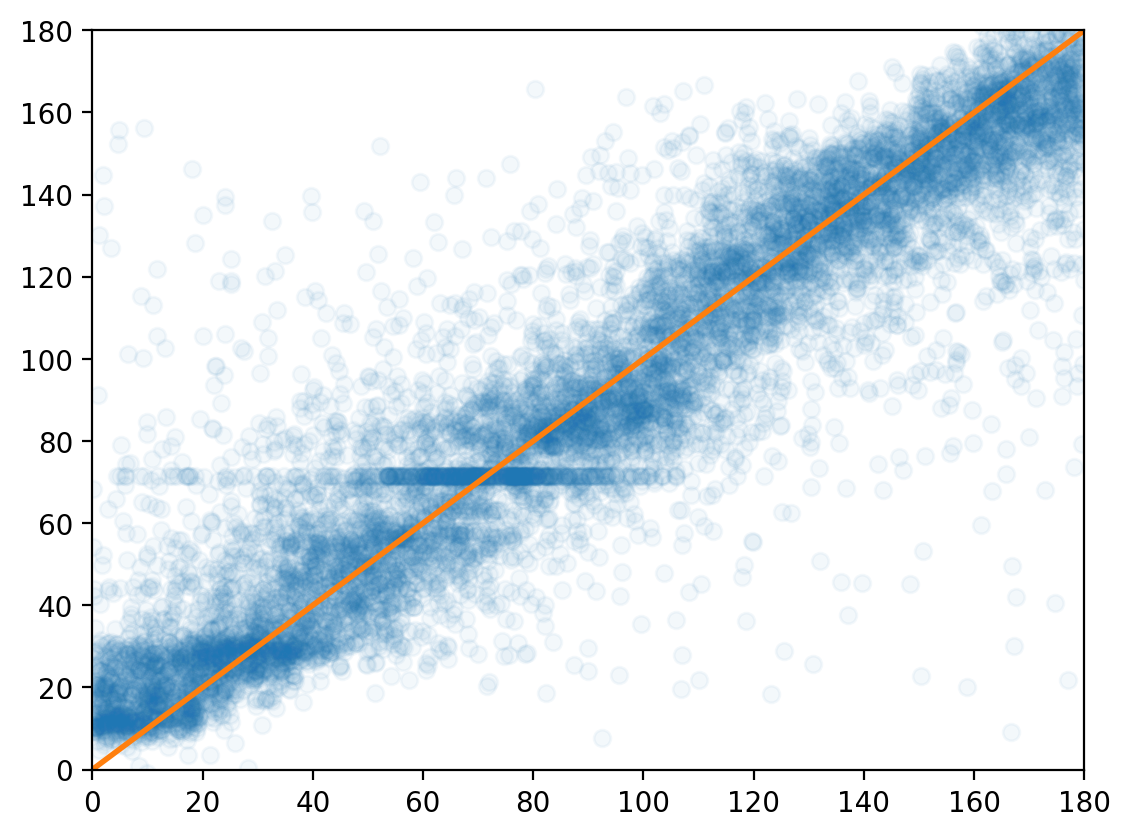

In [131]:
plt.scatter(y_test, yhat_test, alpha=0.05, edgecolors=None)
plt.plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
plt.ylim(0, 180)
plt.xlim(0, 180)

### Posterior predictive

In [132]:
@partial(jax.vmap, in_axes=(0, None, None, None, None))
@partial(jax.jit, static_argnames=("num_params", "reconstruct_fn"))
def sample_and_eval(key, state, X, num_params, reconstruct_fn):
    params_sample = sample_params(key, state, num_params, reconstruct_fn)
    return model.apply(params_sample, X)

In [133]:
keys_sample = jax.random.split(key_eval, 20)
yhat_samples = sample_and_eval(keys_sample, opt_state.params, X_test, num_params, reconstruct_fn).squeeze()
yhat_test = yhat_samples.mean(axis=0)
err_pp = y_test - yhat_test
jnp.abs(err_pp).mean()

DeviceArray(13.4017, dtype=float32)

(0.0, 180.0)

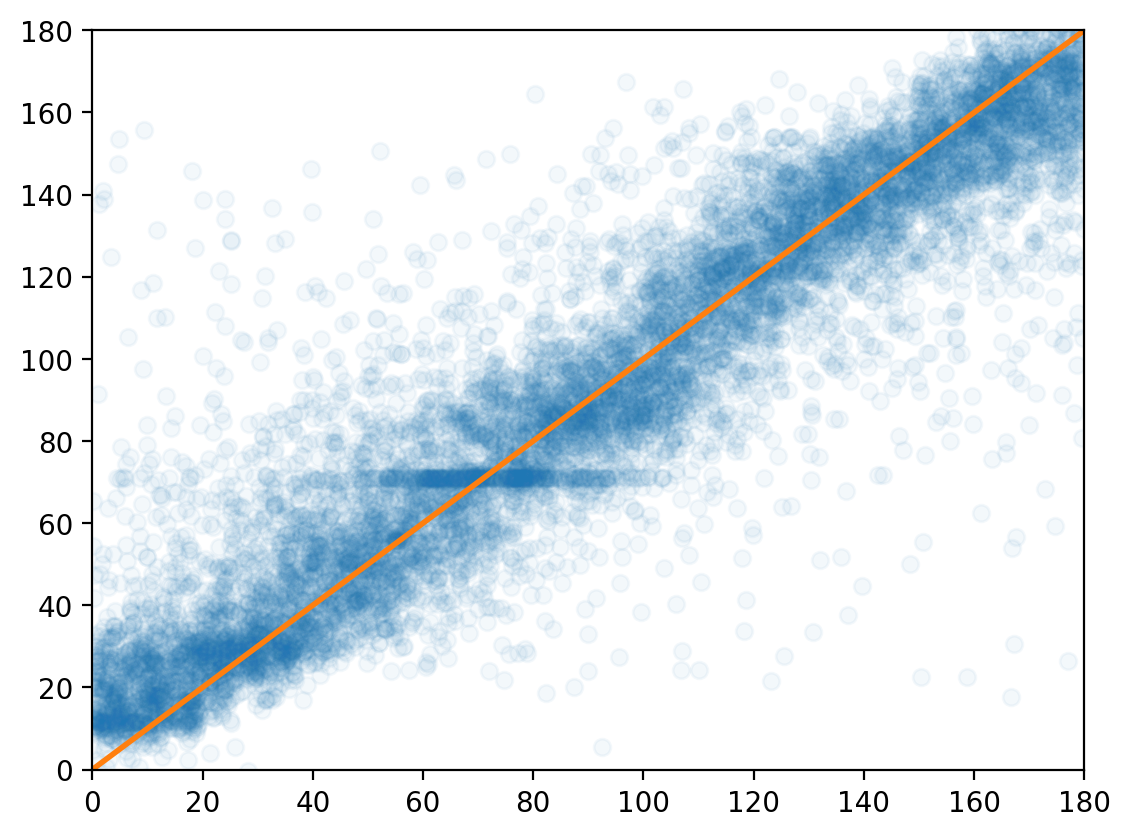

In [134]:
plt.scatter(y_test, yhat_test, alpha=0.05, edgecolors=None)
plt.plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
plt.ylim(0, 180)
plt.xlim(0, 180)

## References

* [1] Laurent Valentin Jospin, Wray Buntine, Farid Boussaid, Hamid Laga, Mohammed Bennamoun: “Hands-on Bayesian Neural Networks -- a Tutorial for Deep Learning Users”, 2020, IEEE Computational Intelligence Magazine ( Volume: 17, Issue: 2, May 2022); [arXiv:2007.06823](http://arxiv.org/abs/2007.06823).